<a href="https://colab.research.google.com/github/tasosnikitakis/Cheminformatics-Solubility-Prediction/blob/main/ADMET_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Define the ADMET Property**

In drug discovery, ADMET (Absorption, Distribution, Metabolism, Excretion, and Toxicity) properties are critical for determining whether a potential drug molecule is viable. A compound might be highly effective at its target, but if it's not absorbed by the body, is toxic, or is metabolized too quickly, it will fail as a drug.

For this project, we will focus on a fundamental "A" and "D" property: Aqueous Solubility. This property, often measured as LogS (the logarithm of the molar solubility), dictates how well a compound dissolves in water. Poor solubility can lead to low absorption and bioavailability, making it a key failure point for many drug candidates. Our objective is to build a machine learning model that can predict the LogS of a molecule based solely on its chemical structure.

**Sourcing and Downloading Data**

To train our model, we need a dataset of molecules with experimentally measured solubility values. We will use a well-known dataset published by John S. Delaney in his 2004 paper, "ESOL: Estimating Aqueous Solubility Directly from Molecular Structure".

About the Dataset:

Content: It contains 1144 diverse small organic molecules.
Features: For each molecule, it provides the chemical structure as a SMILES string (a text-based representation of a molecule) and its measured LogS value.
Source: The data is publicly available and is considered a standard benchmark for Quantitative Structure-Activity Relationship (QSAR) models.
We will load this data directly from a public repository into a pandas DataFrame, which provides a convenient tabular structure for us to work with.

In [2]:
import pandas as pd

# The URL to the raw CSV data file of the Delaney dataset
url = 'https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv'

try:
    # Read the data from the URL into a pandas DataFrame.
    solubility_df = pd.read_csv(url)

    print("Data loaded successfully!")
    # Display the first 5 rows of the DataFrame to inspect the data
    print("\nFirst 5 rows of the dataset:")
    print(solubility_df.head())

    # Display some information about the DataFrame
    print("\nDataset Information:")
    solubility_df.info()

except Exception as e:
    print(f"An error occurred: {e}")
    print("\nPlease ensure you have an internet connection and the pandas library is installed (`pip install pandas`).")
    print(f"You can also manually download the file from: {url}")

Data loaded successfully!

First 5 rows of the dataset:
                      Compound ID  measured log(solubility:mol/L)  \
0       1,1,1,2-Tetrachloroethane                           -2.18   
1           1,1,1-Trichloroethane                           -2.00   
2       1,1,2,2-Tetrachloroethane                           -1.74   
3           1,1,2-Trichloroethane                           -1.48   
4  1,1,2-Trichlorotrifluoroethane                           -3.04   

   ESOL predicted log(solubility:mol/L)               SMILES  
0                                -2.794       ClCC(Cl)(Cl)Cl  
1                                -2.232         CC(Cl)(Cl)Cl  
2                                -2.549       ClC(Cl)C(Cl)Cl  
3                                -1.961           ClCC(Cl)Cl  
4                                -3.077  FC(F)(Cl)C(F)(Cl)Cl  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1144 entries, 0 to 1143
Data columns (total 4 columns):
 #   Column            

**Data Cleaning and Preparation**

Before we can use the data, we need to prepare it for our cheminformatics workflow. This involves two main tasks:

Tidying the DataFrame: We will select only the columns essential for our model—the SMILES strings and the LogS values. We'll also rename these columns to be simpler (smiles, logS) for easier access in our code.
Creating RDKit Molecule Objects: The SMILES strings are currently just text. To perform chemical calculations, we must convert them into a format that a cheminformatics library can understand. We will use the powerful RDKit library to parse each SMILES string and create a "molecule object". This object contains a rich representation of the molecule's structure, including its atoms, bonds, and connectivity, which is essential for the next step. This process also serves to validate the SMILES strings, ensuring they represent valid chemical structures.

In [3]:
#RDKit library installation
!pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 66.5 MB/s eta 0:00:00


In [8]:
# Install RDKit first if the environment has reset
!pip install rdkit-pypi

import pandas as pd
from rdkit import Chem

# --- Let's start fresh to ensure everything is correct ---

# 1. Load the data from the URL
url = 'https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv'
solubility_df = pd.read_csv(url)

# 2. DEBUG: Print the exact column names to see what pandas loaded
print("Exact column names from the file:")
print(solubility_df.columns)
print("-" * 30) # A separator for clarity

# 3. Select relevant columns and rename them
#    We will use the exact names printed above.
df = solubility_df[['SMILES', 'measured log(solubility:mol/L)']].copy()
df.rename(columns={'SMILES': 'smiles', 'measured log(solubility) in mols/L': 'logS'}, inplace=True)

print("DataFrame after selecting and renaming columns:")
print(df.head())
print("-" * 30)

# 4. Create RDKit molecule objects from SMILES strings
mols = [Chem.MolFromSmiles(smi) for smi in df['smiles']]

# Check for any molecules that RDKit failed to parse (good practice)
invalid_smiles_count = mols.count(None)
if invalid_smiles_count > 0:
    print(f"Warning: RDKit could not parse {invalid_smiles_count} SMILES strings.")
    df = df[pd.Series(mols).notna()] # Remove rows with invalid SMILES
    mols = [m for m in mols if m is not None]

# Add the molecule objects as a new column in our DataFrame
df['molecule'] = mols

print(f"Successfully created {len(df)} RDKit molecule objects.")
print("\nFinal prepared DataFrame with 'molecule' column:")
print(df.head())

Exact column names from the file:
Index(['Compound ID', 'measured log(solubility:mol/L)',
       'ESOL predicted log(solubility:mol/L)', 'SMILES'],
      dtype='object')
------------------------------
DataFrame after selecting and renaming columns:
                smiles  measured log(solubility:mol/L)
0       ClCC(Cl)(Cl)Cl                           -2.18
1         CC(Cl)(Cl)Cl                           -2.00
2       ClC(Cl)C(Cl)Cl                           -1.74
3           ClCC(Cl)Cl                           -1.48
4  FC(F)(Cl)C(F)(Cl)Cl                           -3.04
------------------------------
Successfully created 1144 RDKit molecule objects.

Final prepared DataFrame with 'molecule' column:
                smiles  measured log(solubility:mol/L)  \
0       ClCC(Cl)(Cl)Cl                           -2.18   
1         CC(Cl)(Cl)Cl                           -2.00   
2       ClC(Cl)C(Cl)Cl                           -1.74   
3           ClCC(Cl)Cl                           -1.48   


In [10]:
# Let's rename the column to the simpler 'logS'
df.rename(columns={'measured log(solubility:mol/L)': 'logS'}, inplace=True)

# Also rename the smiles column if it didn't get renamed
if 'SMILES' in df.columns:
    df.rename(columns={'SMILES': 'smiles'}, inplace=True)

print("Corrected column names:")
print(df.columns)

Corrected column names:
Index(['smiles', 'logS', 'molecule'], dtype='object')


**Molecular Feature Calculation (Feature Engineering)**

A machine learning model cannot understand a chemical structure directly; it needs numerical inputs. Feature Engineering is the process of converting our abstract molecule objects into a set of meaningful numbers, known as molecular descriptors. These descriptors are numerical values that quantify different physicochemical properties of a molecule.

Using RDKit, we will calculate five common and interpretable descriptors for each molecule:

**MolWt**: Molecular Weight, which represents the size of the molecule.
**MolLogP**: The logarithm of the octanol-water partition coefficient, a key measure of a molecule's hydrophobicity (greasiness).
**NumHDonors**: The number of hydrogen bond donors, related to polarity.
**NumHAcceptors**: The number of hydrogen bond acceptors, also related to polarity.
**TPSA**: Topological Polar Surface Area, another measure of polarity that is important for cell membrane permeability.
The output of this step will be a clean, numerical DataFrame where each row is a molecule and each column is a feature (a descriptor or the target logS value), ready for model training.

In [11]:
from rdkit.Chem import Descriptors
import numpy as np

# Define the list of descriptor functions we want to calculate
descriptor_list = {
    "MolWt": Descriptors.MolWt,
    "MolLogP": Descriptors.MolLogP,
    "NumHDonors": Descriptors.NumHDonors,
    "NumHAcceptors": Descriptors.NumHAcceptors,
    "TPSA": Descriptors.TPSA
}

# Creating a function to calculate descriptors for a single molecule
def calculate_descriptors(molecule):
    try:
        # Calculate all descriptors in our list for the given molecule
        return [func(molecule) for func in descriptor_list.values()]
    except:
        # Return a list of NaNs if calculation fails
        return [np.nan] * len(descriptor_list)

# Apply the function to the 'molecule' column and create a new DataFrame
descriptors_df = pd.DataFrame(
    [calculate_descriptors(mol) for mol in df['molecule']],
    columns=descriptor_list.keys()
)

# --- Combine our features (descriptors) and target (logS) ---

# First, drop any rows where descriptor calculation might have failed
descriptors_df.dropna(inplace=True)

# Concatenate the descriptors DataFrame with our original DataFrame
# We align them by index to make sure everything matches up.
model_df = pd.concat([df.loc[descriptors_df.index], descriptors_df], axis=1)

# We no longer need the 'smiles' and 'molecule' columns for the model itself
model_df.drop(['smiles', 'molecule'], axis=1, inplace=True)


print("Shape of the final DataFrame for modeling:", model_df.shape)
print("\nFirst 5 rows of our final model-ready data:")
print(model_df.head())

Shape of the final DataFrame for modeling: (1144, 6)

First 5 rows of our final model-ready data:
   logS    MolWt  MolLogP  NumHDonors  NumHAcceptors  TPSA
0 -2.18  167.850   2.5954           0              0   0.0
1 -2.00  133.405   2.3765           0              0   0.0
2 -1.74  167.850   2.5938           0              0   0.0
3 -1.48  133.405   2.0289           0              0   0.0
4 -3.04  187.375   2.9189           0              0   0.0


**Splitting the Dataset**
 We split our dataset into two parts:

Training Set: (typically 80%) is what the machine learning model will actually "see" and learn the underlying patterns from.
Testing Set: This remaining portion (typically 20%). We use this set at the very end to evaluate how well our model generalizes to new, unknown data.
This process prevents overfitting. We will use the train_test_split function from the popular Scikit-learn library to perform this split.

In [12]:
from sklearn.model_selection import train_test_split

# 1. Define our Features (X) and Target (y)
# X contains all the descriptor columns (our model's input)
X = model_df.drop('logS', axis=1)

# y contains only our target variable, logS (what the model predicts)
y = model_df['logS']


# 2. Split the data into training and testing sets
# test_size=0.2 means we'll use 20% of the data for the test set.
# random_state=42 ensures that we get the same random split every time we run the code.
# This makes our results reproducible.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 3. Print the shapes of the new data sets to verify the split
print("Shape of Features (X):", X.shape)
print("Shape of Target (y):", y.shape)
print("-" * 30)
print("Shape of Training Features (X_train):", X_train.shape)
print("Shape of Testing Features (X_test):", X_test.shape)
print("Shape of Training Target (y_train):", y_train.shape)
print("Shape of Testing Target (y_test):", y_test.shape)

Shape of Features (X): (1144, 5)
Shape of Target (y): (1144,)
------------------------------
Shape of Training Features (X_train): (915, 5)
Shape of Testing Features (X_test): (229, 5)
Shape of Training Target (y_train): (915,)
Shape of Testing Target (y_test): (229,)


**Model Selection and Initial Training**

Now that we have our training and testing sets, it's time to choose a machine learning algorithm and train it. Since our goal is to predict a continuous value (the logS), this is a regression problem.

There are many great regression algorithms, but we will start with a powerful and popular one: the Random Forest Regressor.

We chose Random Forest because of the following characteristics:

**High Performance**: It's an "ensemble" model, meaning it builds many individual decision trees and combines their predictions. This collective approach makes it highly accurate and robust.

**Handles Complexity**: It can capture complex, non-linear relationships between the molecular features and the solubility, which are common in chemistry.
**Resistant to Overfitting**: Compared to a single decision tree, it is much less likely to "memorize" the training data.

**No Feature Scaling Needed**: It does not require us to scale our input features (like MolWt and MolLogP) to be on the same range.

In this step, we will instantiate the model and train it on our X_train and y_train data using the .fit() method.

In [13]:
from sklearn.ensemble import RandomForestRegressor

# 1. Instantiate the model
# We use random_state=42 to ensure the model's random processes are the same each time,
# leading to reproducible results. n_estimators is the number of trees in the forest.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)


# 2. Fitting the model on the training data
print("Training the Random Forest model...")
rf_model.fit(X_train, y_train)
print("Model training complete.")


# 3. Use the trained model to make predictions on the test set
y_pred_test = rf_model.predict(X_test)

# We can also see how the model performs on the data it was trained on
y_pred_train = rf_model.predict(X_train)

# The variables y_pred_test and y_pred_train now hold the model's predictions.
# In the next step, we will evaluate how good these predictions are.
print("\nPredictions have been made on the training and testing sets.")

Training the Random Forest model...
Model training complete.

Predictions have been made on the training and testing sets.


**Model Validation**

Having completed the training we must now rigorously evaluate its performance on both the data it was trained on and the unseen test data. This tells us not only how accurate the model is and whether we have overfitting.

For our regression task, we will use two standard metrics:

Coefficient of Determination (R
2
 ): This metric indicates the proportion of the variance in the dependent variable (logS) that is predictable from the independent variables (our molecular features). An R
2
  value of 1.0 means the model makes perfect predictions. An R
2
  of 0 means the model is no better than just predicting the mean of the data. The closer to 1.0, the better.

Root Mean Squared Error (RMSE): This is the square root of the average of squared differences between the actual and predicted values. The RMSE is in the same unit as our target variable (logS), making it easy to interpret. A smaller RMSE value indicates a better fit to the data.

By comparing the R
2
  and RMSE on the training set versus the test set, we can diagnose the model's health. If the training scores are much better than the test scores, it's a clear sign of overfitting.

Finally, we will create a scatter plot of the actual vs. predicted values. For a good model, the points should fall closely along a diagonal line where Actual = Predicted.

Model Performance Evaluation
--------------------------
Training R-squared (R²): 0.9790
Training RMSE: 0.3041
--------------------------
Testing R-squared (R²): 0.8963
Testing RMSE: 0.6720


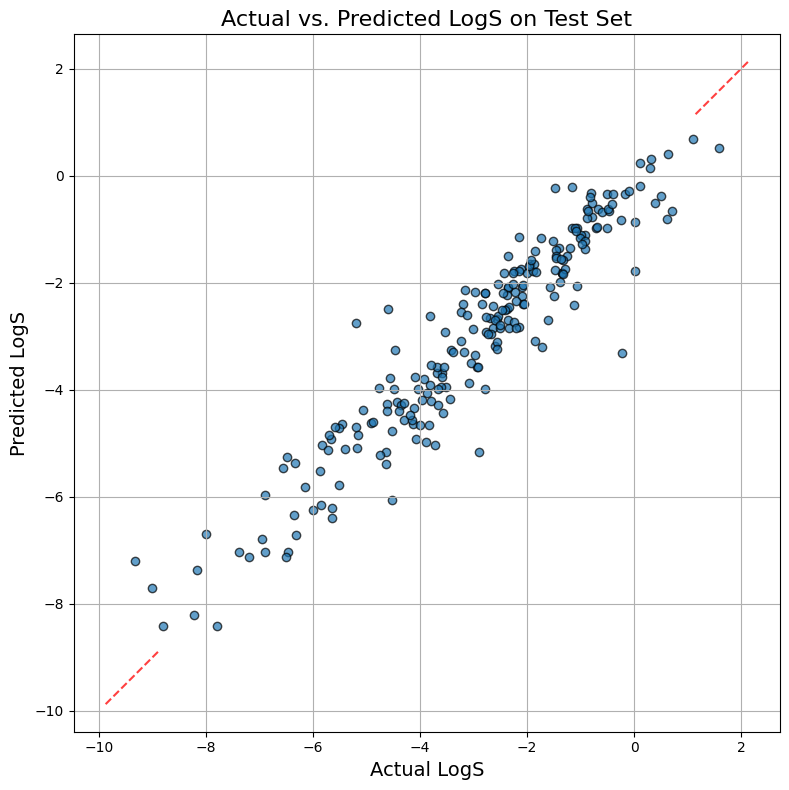

In [14]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# 1. Evaluate the model on the TRAINING data
r2_train = r2_score(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

# 2. Evaluate the model on the TESTING data
r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# 3. Print the performance metrics
print("Model Performance Evaluation")
print("--------------------------")
print(f"Training R-squared (R²): {r2_train:.4f}")
print(f"Training RMSE: {rmse_train:.4f}")
print("-" * 26)
print(f"Testing R-squared (R²): {r2_test:.4f}")
print(f"Testing RMSE: {rmse_test:.4f}")


# 4. Visualize the results with a scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_test, alpha=0.7, edgecolors='k')

# Add a line for perfect predictions
lims = [min(plt.xlim(), plt.ylim()), max(plt.xlim(), plt.ylim())]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

plt.xlabel("Actual LogS", fontsize=14)
plt.ylabel("Predicted LogS", fontsize=14)
plt.title("Actual vs. Predicted LogS on Test Set", fontsize=16)
plt.grid(True)
plt.axis('equal') # Ensures the x and y axes have the same scale
plt.tight_layout()
plt.show()

**Hyperparameter Tuning**


Our initial model showed signs of overfitting, where it performed significantly better on the training data than on the unseen test data. To address this, we will perform hyperparameter tuning.

Hyperparameters are settings of a model that are not learned from the data itself but are set by the user before the training process begins. For Random Forest, this includes settings like:

**n_estimators**: The number of trees in the forest.
**max_depth**: The maximum depth of each individual tree.
**max_features**: The number of features to consider when looking for the best split.
**min_samples_leaf**: The minimum number of samples required to be at a leaf node.
By tuning these, we can control the model's complexity. For instance, limiting the max_depth can prevent the trees from growing too complex and memorizing noise, thus reducing overfitting.

We will use a technique called Grid Search with Cross-Validation (GridSearchCV) from Scikit-learn. This will automatically test various combinations of these hyperparameters and, through a process of cross-validation on the training set, identify the combination that produces the most generalizable model.

In [15]:
from sklearn.model_selection import GridSearchCV

# 1. Define the grid of hyperparameters to search
# We'll test a few combinations to see if we can improve the model
param_grid = {
    'n_estimators': [50, 100, 200],      # Number of trees in the forest
    'max_depth': [None, 10, 20],       # Maximum depth of the tree
    'max_features': ['sqrt', 'log2'], # Number of features to consider at every split
    'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required at a leaf node
}

# 2. Instantiate the GridSearchCV object
# We're using our original rf_model, but GridSearchCV will create new versions of it.
# cv=5 means 5-fold cross-validation.
# n_jobs=-1 uses all available CPU cores to speed up the process.
# 'neg_mean_squared_error' is used because grid search maximizes a score,
# so it maximizes the negative of MSE (which is equivalent to minimizing MSE).
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           scoring='neg_mean_squared_error',
                           verbose=2)

# 3. Fit the grid search to the training data
print("Performing hyperparameter tuning with GridSearchCV...")
grid_search.fit(X_train, y_train)

# 4. Print the best parameters found
print("\nBest hyperparameters found by GridSearchCV:")
print(grid_search.best_params_)

# 5. Get the best model
best_rf_model = grid_search.best_estimator_

# 6. Evaluate the new, tuned model
y_pred_train_best = best_rf_model.predict(X_train)
y_pred_test_best = best_rf_model.predict(X_test)

r2_train_best = r2_score(y_train, y_pred_train_best)
rmse_train_best = np.sqrt(mean_squared_error(y_train, y_pred_train_best))
r2_test_best = r2_score(y_test, y_pred_test_best)
rmse_test_best = np.sqrt(mean_squared_error(y_test, y_pred_test_best))


# 7. Print the performance of the tuned model
print("\n--- Performance of Tuned Model ---")
print(f"Training R-squared (R²): {r2_train_best:.4f}")
print(f"Training RMSE: {rmse_train_best:.4f}")
print("-" * 32)
print(f"Testing R-squared (R²): {r2_test_best:.4f}")
print(f"Testing RMSE: {rmse_test_best:.4f}")

Performing hyperparameter tuning with GridSearchCV...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best hyperparameters found by GridSearchCV:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200}

--- Performance of Tuned Model ---
Training R-squared (R²): 0.9670
Training RMSE: 0.3813
--------------------------------
Testing R-squared (R²): 0.8936
Testing RMSE: 0.6808


**Interpretation of Results - Feature Importance**


Which of the molecular features that we engineered are the most important for predicting aqueous solubility?

A major advantage of tree-based models like Random Forest is that they can provide feature importance scores. These scores represent the relative contribution of each feature to the model's predictive accuracy. A higher score means the feature was more important.

Analyzing feature importance is critical because it connects the abstract machine learning model back to the real-world chemistry. It allows us to gain scientific insights into the structure-property relationships and validate whether the model is making decisions based on sound chemical principles. For example, for solubility, we might expect features related to polarity and size to be very important.

Feature Importances from the Tuned Model:
         Feature  Importance
1        MolLogP    0.532722
0          MolWt    0.295239
4           TPSA    0.082427
3  NumHAcceptors    0.070901
2     NumHDonors    0.018710


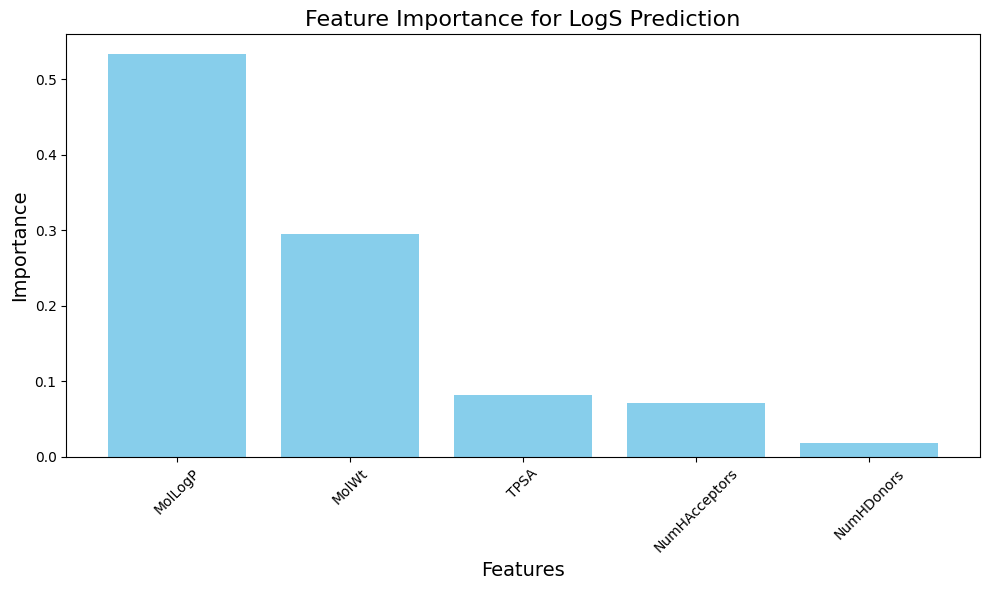

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Get feature importances from our best tuned model
importances = best_rf_model.feature_importances_
feature_names = X_train.columns

# 2. Create a DataFrame for easier visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 3. Print the feature importances
print("Feature Importances from the Tuned Model:")
print(feature_importance_df)

# 4. Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Features', fontsize=14)
plt.ylabel('Importance', fontsize=14)
plt.title('Feature Importance for LogS Prediction', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Interpretation of Feature Importance Results**


Our tuned model has ranked the molecular features as follows:

**MolLogP (53.3%)**: This is, by a large margin, the most important feature. MolLogP is the logarithm of the octanol-water partition coefficient, which is the classic measure of a molecule's lipophilicity (or hydrophobicity/greasiness). It makes perfect chemical sense that this is the #1 predictor of aqueous (water) solubility. As a general rule, the more greasy/hydrophobic a molecule is (higher LogP), the less soluble it is in water. Our model correctly learned this fundamental chemical principle.

**MolWt (29.5%)**: Molecular Weight is the second most important feature. This is also chemically intuitive. Larger and heavier molecules generally have lower solubility because it requires more energy to create a "cavity" for them in the water's hydrogen-bonded network.

**TPSA, NumHAcceptors, NumHDonors (combined ~18%)**: These three features all relate to a molecule's polarity and its ability to form hydrogen bonds with water molecules. It is this hydrogen bonding that allows polar molecules like sugar to dissolve so well. For the specific dataset of halogenated hydrocarbons we are using, many molecules have few or no hydrogen bonding capabilities, which is likely why these features are less dominant than MolLogP and MolWt. Still, they provide a crucial part of the picture.

In summary: Our model has successfully learned key physicochemical principles from the data. It concluded that a molecule's solubility is primarily driven by its hydrophobicity and its size, with polarity playing a secondary but still significant role. This is a scientifically sound and interpretable result.